In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read data
train = pd.read_csv('/content/drive/MyDrive/day10/train.csv')
test = pd.read_csv('/content/drive/MyDrive/day10/test.csv')

train.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
#Checking missing values in train and test set
print('Nº of missing values in train set: ', train.isnull().any().sum())
print()
print('Nº of missing values in test set: ', test.isnull().any().sum())

Nº of missing values in train set:  0

Nº of missing values in test set:  0


In [ ]:
X = np.array(train.drop('label',axis=1))/ 255.
X = X.reshape((-1,28,28,1))

y = np.array(train['label'])

In [ ]:
# Split train and test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (33600, 28, 28, 1)
Y_train: (33600,)
X_test:  (8400, 28, 28, 1)
Y_test:  (8400,)


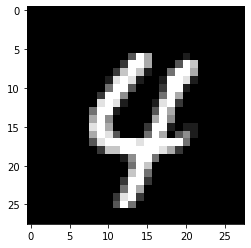

In [ ]:
# pick a sample to plot
sample = 5
image = train_X[sample].reshape(28,28)

# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# defining model parameters 
batch_size = 128
epochs = 110
epochs_to_wait_to_improve = 10
num_classes = max(pd.unique(train['label'])) +1 # 10 classes

# fix random seed for reproducibility
seed = 7
random.seed(seed)

In [ ]:
# create a data generator
datagen = ImageDataGenerator(
                             rotation_range=12,
                             width_shift_range=0.11,
                             height_shift_range=0.11,
                             shear_range=0.15,
                             zoom_range = 0.09, 
                             validation_split=0.3,
                             horizontal_flip=False, 
                             vertical_flip=False
                            )

In [ ]:
# Define the training generator
train_generator = datagen.flow(train_X, 
                               train_y, 
                               batch_size=batch_size,
                               shuffle=True,
                               subset='training')

# Define the testing generator
val_generator = datagen.flow(test_X, 
                             test_y, 
                             batch_size=batch_size,
                             subset='validation')

In [ ]:
# Define the CNN model 

model = Sequential() # Initialize the sequential model

# Add CNN convolutions with BatchNormalization and MaxPooling2D
# Avoid overfitting with Dropout
model.add(Conv2D(32, kernel_size = (3,3), input_shape=(28, 28, 1), padding = 'Same', activation='relu'))
model.add(Conv2D(64, kernel_size = (3,3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3,3), padding = 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='valid'))
model.add(Dropout(0.2))

# Convert our matrix to 1-D set of features 
model.add(Flatten())

# Add fully-conected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Defining the call backs EarlyStopping and myCallback which will stop the training
# if the accuracy reaches 99%

class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

# Instantiate callback
mycallback = myCallback()


early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=epochs_to_wait_to_improve,
                                        verbose = 2,
                                        restore_best_weights=True)

# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9)
#optimizer = 'RMSprop'

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 64)        2

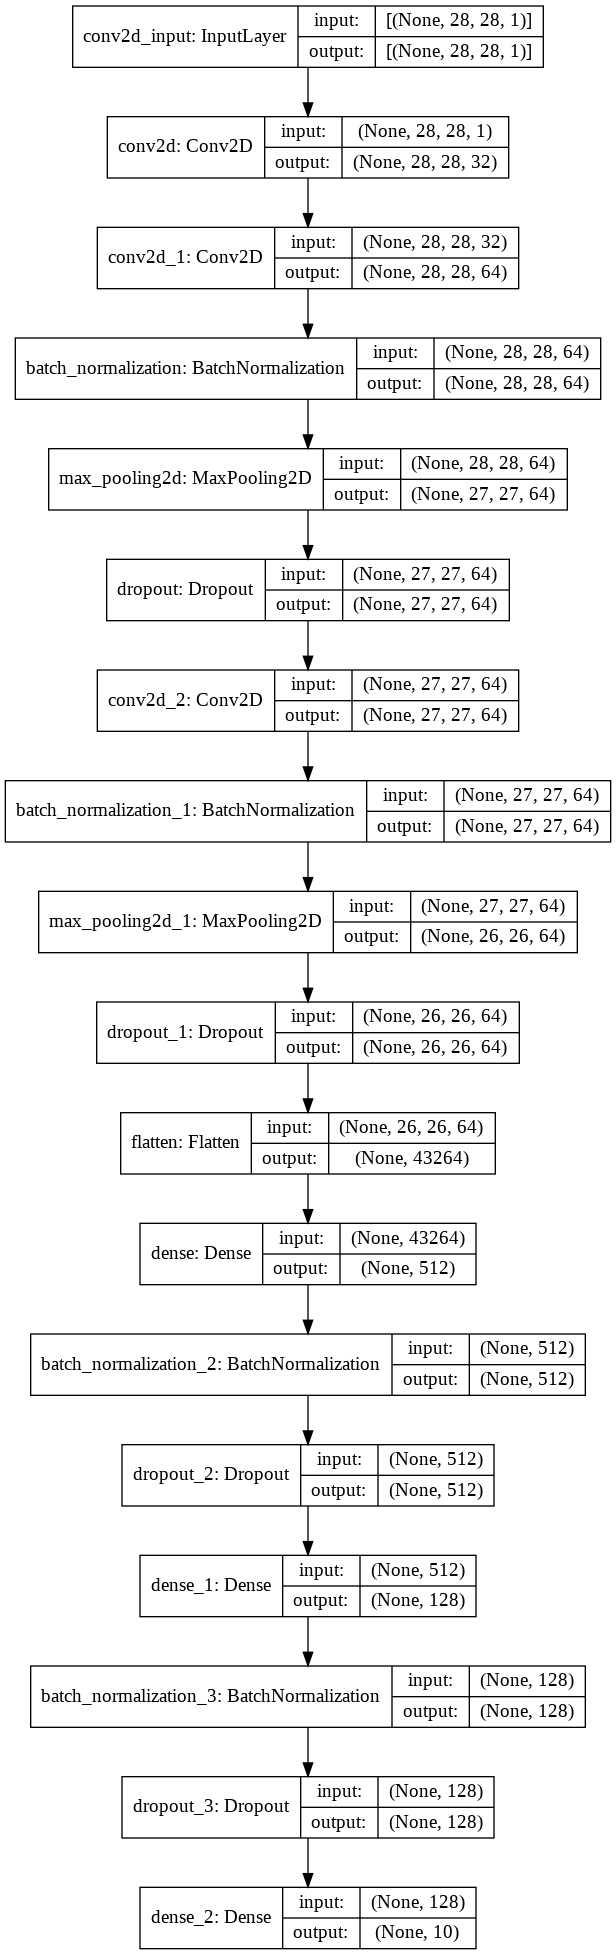

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator, 
          callbacks=[mycallback,early_stopping_callback])

Epoch 1/110
184/184 [==============================] - 40s 46ms/step - loss: 0.3950 - accuracy: 0.8817 - val_loss: 55.8752 - val_accuracy: 0.1091
Epoch 2/110
184/184 [==============================] - 8s 44ms/step - loss: 0.1322 - accuracy: 0.9593 - val_loss: 99.5944 - val_accuracy: 0.1091
Epoch 3/110
184/184 [==============================] - 8s 45ms/step - loss: 0.0992 - accuracy: 0.9693 - val_loss: 13.3201 - val_accuracy: 0.2802
Epoch 4/110
184/184 [==============================] - 8s 45ms/step - loss: 0.0850 - accuracy: 0.9740 - val_loss: 0.1610 - val_accuracy: 0.9528
Epoch 5/110
184/184 [==============================] - 8s 44ms/step - loss: 0.0801 - accuracy: 0.9751 - val_loss: 0.1024 - val_accuracy: 0.9722
Epoch 6/110
184/184 [==============================] - 8s 44ms/step - loss: 0.0626 - accuracy: 0.9801 - val_loss: 0.0898 - val_accuracy: 0.9726
Epoch 7/110
184/184 [==============================] - 8s 44ms/step - loss: 0.0582 - accuracy: 0.9828 - val_loss: 0.0796 - val_accur

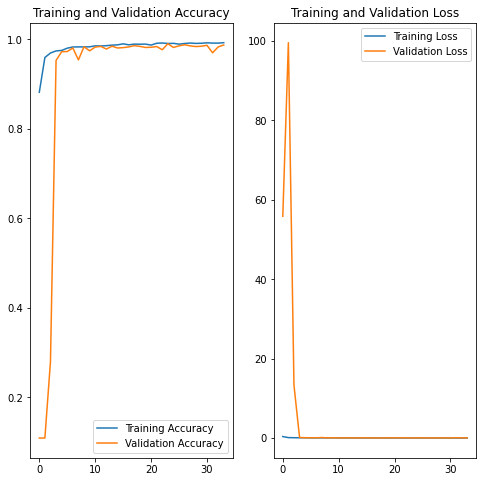

In [ ]:
# Visualize training results with matplotlib
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# evaluate model with test_X from train_test_split
test_loss, test_acc = model.evaluate(test_X, test_y, verbose=5)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.9928571581840515


In [ ]:
Y_pred = model.predict(test_X)
val_preds = np.argmax(Y_pred, axis=1)

val_trues = test_y
metrics.classification_report(val_trues, val_preds)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00       835\n           1       1.00      0.99      1.00       918\n           2       0.99      1.00      0.99       832\n           3       1.00      0.99      0.99       842\n           4       1.00      0.98      0.99       838\n           5       0.99      1.00      0.99       745\n           6       0.99      1.00      0.99       822\n           7       0.99      1.00      1.00       868\n           8       0.99      0.99      0.99       793\n           9       0.99      0.99      0.99       907\n\n    accuracy                           0.99      8400\n   macro avg       0.99      0.99      0.99      8400\nweighted avg       0.99      0.99      0.99      8400\n'

In [ ]:
model_json = model.to_json()
with open("model_json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")